# Maximum Likelihood vs CDF-Fit (Spiral B)

In [57]:
import matplotlib.pyplot as plot
import numpy as np
import sympy as sp

from sympy import Symbol, lambdify

import math
from math import exp, log, sqrt
from scipy.optimize import curve_fit, fsolve

import DistA as dist

from StopWatch import StopWatch
from LocUtil import LogGrid1, Grid1, MinMax, UnZip
from LocMath import RandLog

#### Constants

In [41]:
aTrue = 1.7

nMin = 30
nMax = 30_000
nN = 300

givenSeed = None

nPlot = 101
figSize = (9, 6.5)

#### Generate List of N's

In [12]:
nL = tuple(round(RandLog(nMin,nMax)) for _ in range(nN))

## Estimation Code

In [13]:
termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
termSym

(1 - 2*x)/(a - 2*x*(a - 1))

#### Hand Coded

In [20]:
sampTest = np.array(tuple(np.float64(dist.GenSamp(aTrue)) for _ in range(10_000)))

In [21]:
def MaxEst(samp):
  def f(a, samp):
    assert(type(samp) == np.ndarray)
    terms = (1 - 2*samp) / (a + 2*(1 - a) * samp)
    result = np.sum(terms)
    return result

  result = fsolve(f,1, args=samp)
  return result[0]

In [23]:
timer = StopWatch(running=True)
est = MaxEst(sampTest)
timer.Stop()
est, f'{timer.Delta()}'

(1.7070347189096287, '0:00:00.002608')

### MLE Estimator

In [68]:
def MleEst(samp):
  termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
  
  fTemp = (
    'def f(a, x):\n'
    '  terms = {}\n'
    '  result = np.sum(terms)\n'
    '  return result'
  )
  fCode = fTemp.format(termSym)
  # print(fCode)
  
  execScope = {}
  exec(fCode, globals(), execScope)
  f = execScope['f']
  
  timer = StopWatch(running=True)
  ans = fsolve(f,1, args=samp)
  timer.Stop()

  return ans[0]

In [69]:
timer = StopWatch(running=True)
est = MleEst(sampTest)
timer.Stop()
est, f'{timer.Delta()}'

(1.7070347189096287, '0:00:00.024414')

### Generate Data

In [70]:
mleEst = []

for n in nL:
  samp = np.array(tuple(dist.GenSamp(aTrue) for _ in range(n)))
  
  mEst = MleEst(samp)
  mleEst.append(mEst)

In [ ]:
nLog = tuple(log(n) for n in nL)

In [99]:
mleErr = list(aEst - aTrue for aEst in mleEst)
mleAbsErr = list(abs(e) for e in mleErr)
mleLogErr = [log(e) for e in mleAbsErr]

## Fit Allowing the Power to Vary

In [100]:
linFit = lambda n, a0,a1: a0 + a1*n

In [101]:
mleLinFit,_ = curve_fit(linFit, nLog, mleLogErr)
mleLinFit

array([-0.18150949, -0.52010706])

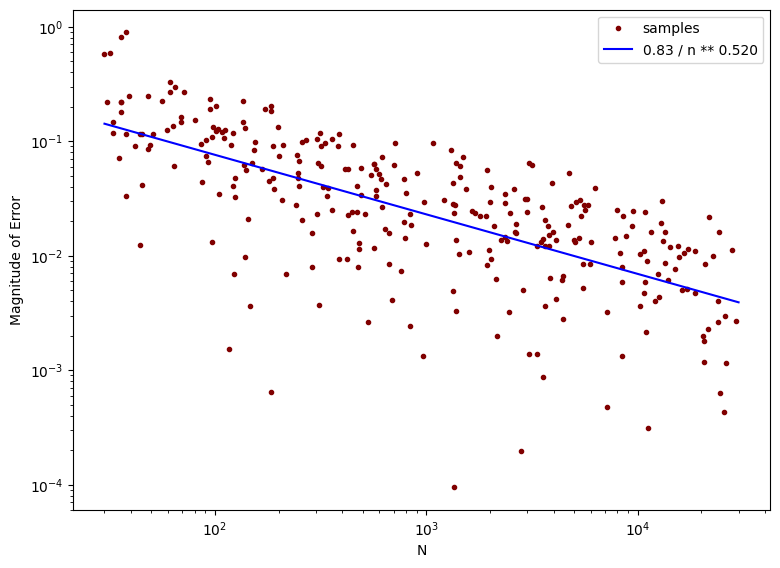

In [102]:
plot.figure(figsize=figSize)
plot.loglog(nL, mleAbsErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

a0,a1 = mleLinFit
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / n ** {-a1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Fit Constraining Power to be -1/2

In [108]:
komFit = lambda n, k: k - n/2

In [109]:
mleKomFit,_ = curve_fit(komFit, nLog, mleLogErr)
mleKomFit

array([-0.31907736])

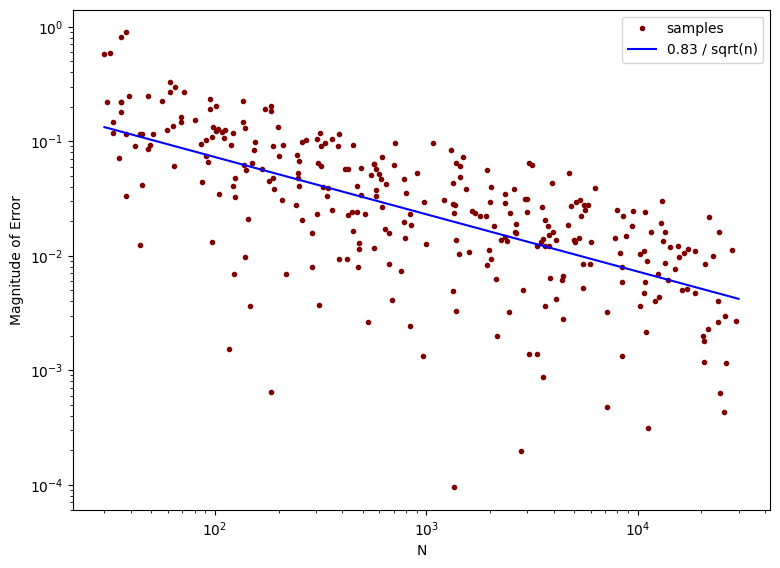

In [110]:
plot.figure(figsize=figSize)
plot.loglog(nL, mleAbsErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = mleKomFit[0]
fitGrid = [exp(k) / sqrt(n) for n in nGrid]
text = f'{exp(a0):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

### CDF-Fit

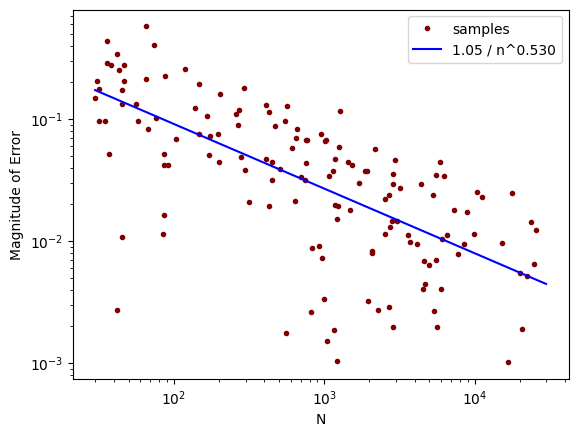

In [13]:
plot.loglog(nL, cdfErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

a0,a1 = cdfParam
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / n^{-a1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Fit Assuming One Over Square-Root of N

In [31]:
kolmoForm = lambda n, k: k - n/2

In [32]:
mleParam, _ = curve_fit(kolmoForm, nLog, mleLogErr)
mleParam

array([-0.16365491])

In [33]:
cdfParam, _ = curve_fit(kolmoForm, nLog, cdfLogErr)
cdfParam

array([-0.16199716])

### Maximum Likelihood

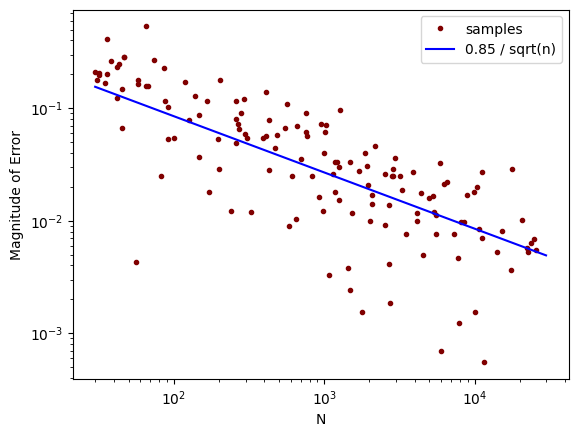

In [34]:
plot.loglog(nL, mleErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = mleParam[0]
fitGrid = [exp(k) / sqrt(n) for n in nGrid]
text = f'{exp(k):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

### CDF-Fit

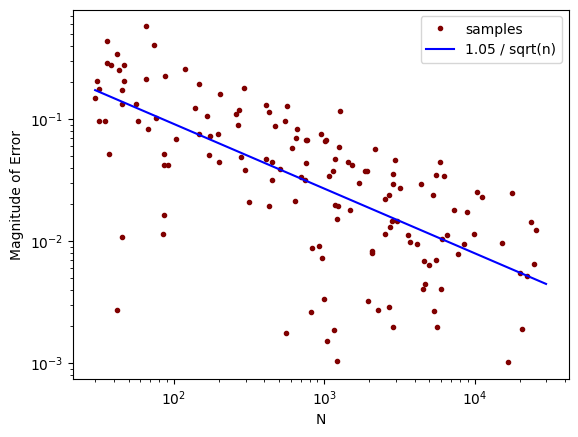

In [35]:
plot.loglog(nL, cdfErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = cdfParam[0]
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Pair Match

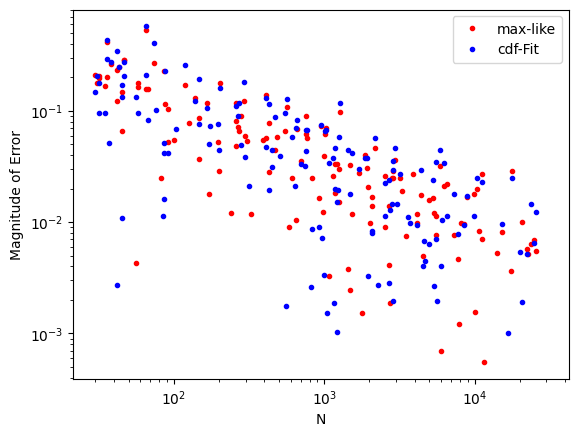

In [39]:
plot.loglog(nL, mleErr, '.', color='red', label='max-like')
plot.loglog(nL, cdfErr, '.', color='blue', label='cdf-Fit')

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

There appears to be near random superiority